In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

adj = pd.read_csv('adj.txt', header=None)
# make adj matrix
adj_matrix = np.zeros((len(adj),len(adj)))
for i in range(len(adj)):
    for j in range(len(adj)):
        if i == j:
            continue
        if str(j) in adj.iloc[i,0].split(' '):
            adj_matrix[i,j] = 1
            adj_matrix[j,i] = 1
# label            
label = np.loadtxt('karate_label.txt')

In [2]:
from typing import List

class Node2Vec:
    def __init__(self,
                 adj_matrix,
                 embedding_dim=2,
                 walks_per_vertex=5,
                 walk_len=10,
                 window_size=3,
                 num_negetive_sample=5,
                 learning_rate=0.02,
                 p=1, q=1):
        
        self.adj_matrix = adj_matrix
        self.embedding_dim = embedding_dim
        self.walks_per_vertex = walks_per_vertex
        self.walk_len = walk_len
        self.window_size = window_size
        self.learning_rate = learning_rate
        self.k = num_negetive_sample
        self.whole_sampling_prob = np.power(np.sum(adj_matrix, axis=1), 3/4)
        self.p = p
        self.q = q
        
        self.w1 = np.random.rand(len(adj_matrix),embedding_dim)
        self.w2 = np.random.rand(embedding_dim,len(adj_matrix))
        
        self.loss = 0.0
        self.epoch_loss = []
    
    def _biased_walk(self, start_node: int)-> List:
        walk = [0] * self.walk_len
        walk[0] = start_node
        next_node = np.random.choice(np.where(self.adj_matrix[start_node]==1)[0])
        walk[1] = next_node
        node = next_node
        
        for i in range(2, self.walk_len):
            prev_node = walk[i-1]
            node_1 = np.where((self.adj_matrix[node]==1)&(self.adj_matrix[prev_node]==1))[0].tolist()
            node_q = np.where((self.adj_matrix[node]==1)&(self.adj_matrix[prev_node]==0))[0].tolist()
            transition_prob = [1/self.p] + [1] * len(node_1) + [1/self.q] * len(node_q)
            next_node = np.random.choice(a=[prev_node]+node_1+node_q, size=1, p=np.array(transition_prob)/sum(transition_prob), replace=False)
            walk[i] = next_node[0]
            node = next_node[0]
        return walk

    def _softmax(self, a: np.array)-> np.array : 
        c = np.max(a) 
        exp_a = np.exp(a-c)
        sum_exp_a = np.sum(exp_a)
        y = exp_a / sum_exp_a
        return y

    def _skip_gram_train(self, walk: List)-> None:
        for idx, input_node in enumerate(walk):
            # make dataset
            left_idx = idx - self.window_size
            right_idx = idx + self.window_size
            if left_idx < 0: 
                left_idx = 0
            if right_idx > self.walk_len-1: 
                right_idx = self.walk_len
            left_node = walk[left_idx:idx]
            right_node = walk[idx+1:right_idx+1]
            output_node = left_node + right_node

            # forward
            hidden = self.w1[input_node]
            ## |hidden| = (2,)
            out = np.matmul(hidden, self.w2)
            ## |out| = (34,)

            # loss calculate
            self.loss += (-np.sum(out[output_node]) \
                                   + len(output_node)*np.log(np.sum(np.exp(out))))\
                                / (self.walk_len*self.walks_per_vertex*len(self.adj_matrix)) 
            
            # Negative sampling
            # walk에 없는 node중에서 뽑기
            neg_sample_idx = np.delete(np.arange(len(self.adj_matrix)), output_node)
            neg_sampling_prob = self.whole_sampling_prob[neg_sample_idx]
            neg_samples = np.random.choice(a=neg_sample_idx, size=self.k, 
                                           p=neg_sampling_prob/np.sum(neg_sampling_prob),
                                           replace=False)

            # calcaulate gradient
            dEdo = np.zeros(len(out))
            dEdo[neg_samples] = self._softmax(out[neg_samples]) * len(output_node)
            dEdo[output_node] = dEdo[output_node] - 1.0
            dEdw2 = hidden.reshape(self.embedding_dim,1) @ dEdo.reshape(1,len(self.adj_matrix))
            
            # update
            self.w2 = self.w2 - self.learning_rate * dEdw2
            self.w1[input_node] = self.w1[input_node] - \
                self.learning_rate * np.matmul(self.w2, dEdo)

    def train(self)-> float:
        V = np.arange(0, len(self.adj_matrix))
        for _ in range(self.walks_per_vertex):
            # shuffle vertex
            np.random.shuffle(V)
            for start_node in V:
                # random walk
                W = self._biased_walk(start_node)
                # skip-gram
                self._skip_gram_train(W)
             # consider epoch as if all node be start_node
             # = consider epoch as walks_per_vertex
            self.epoch_loss.append(self.loss)
            self.loss = 0.0
        return self.epoch_loss
    
    def show_embedding(self):
        return self.w1, self.w2

## q < 1 < p : DFS

In [65]:
Node2Vec_model = Node2Vec(adj_matrix, embedding_dim=2, walks_per_vertex=20,
                          walk_len=10, window_size=3, learning_rate=0.007,
                          num_negetive_sample=5, p=10, q=0.1)

Node2Vec_loss = Node2Vec_model.train()
Node2Vec_emb, _ = Node2Vec_model.show_embedding()

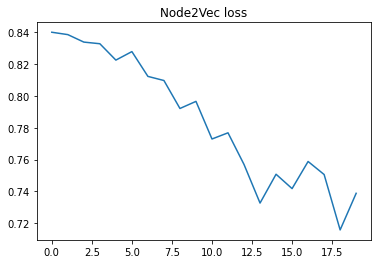

In [66]:
import matplotlib.pyplot as plt
plt.title('Node2Vec loss')
plt.plot(Node2Vec_loss)

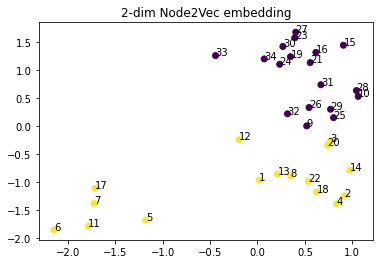

In [67]:
plt.title('2-dim Node2Vec embedding')
plt.scatter(Node2Vec_emb[:,0],Node2Vec_emb[:,1], c=list(map(int, label[:,1])))
for i in range(0, 34):
        plt.text(float(Node2Vec_emb[i,0]), float(Node2Vec_emb[i,1]), i+1 , fontsize=10)
plt.show()

## p < 1 < q : BFS

In [86]:
Node2Vec_model = Node2Vec(adj_matrix, embedding_dim=2, walks_per_vertex=20,
                          walk_len=10, window_size=3, learning_rate=0.007,
                          num_negetive_sample=5, p=0.1, q=10)

Node2Vec_loss = Node2Vec_model.train()

Node2Vec_emb, _ = Node2Vec_model.show_embedding()

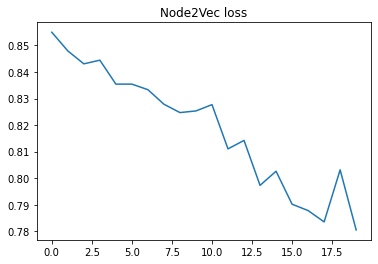

In [87]:
import matplotlib.pyplot as plt
plt.title('Node2Vec loss')
plt.plot(Node2Vec_loss)

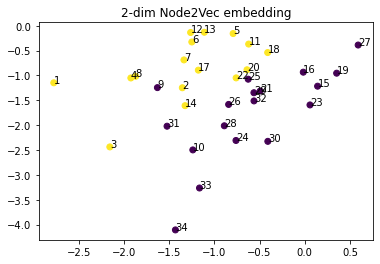

In [88]:
plt.title('2-dim Node2Vec embedding')
plt.scatter(Node2Vec_emb[:,0],Node2Vec_emb[:,1], c=list(map(int, label[:,1])))
for i in range(0, 34):
        plt.text(float(Node2Vec_emb[i,0]), float(Node2Vec_emb[i,1]), i+1 , fontsize=10)
plt.show()